In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hy
import matplotlib.pyplot as plt
from collections import Counter

OS_metadata = pd.read_csv('reference_absorbance_raw_metadata.csv', encoding='latin1')
der_spectra = pd.read_csv('open_specy_reference_FTIR_DERINT.csv')
OS_library = pd.read_csv('reference_absorbance_raw.csv')

OS_metadata = OS_metadata[OS_metadata['SpectrumType']=='FTIR']

der_spectra = der_spectra.dropna(how='any')

def norm_pearson(p,q):
    modp = p/(np.max(p) - np.min(p))
    modq = q/(np.max(q) - np.min(q))
    return stats.pearsonr(modp,modq)[0]

def deriv(p, w):
    return p - np.roll(p,w)

def integ(p):
    return [np.sum(p[:k]) for k in range(1,len(p)+1)]
    
smoothing_window = 7

C:\Users\Shreyas.Patankar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (31,32,33,34,35,36,37,38,39,40,41,42,53,54,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,82,84,86,88,89,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
X = np.transpose(der_spectra.iloc[:,1:].to_numpy())


In [3]:
def add_noise(x):
    if np.abs(x) > 10**(-14):
        return x
    else: return np.random.random_sample()*10**(-15)

nt = np.vectorize(add_noise)
Xp = nt(X)

In [4]:

Z = hy.linkage(Xp, method='average', metric='correlation', optimal_ordering=True)

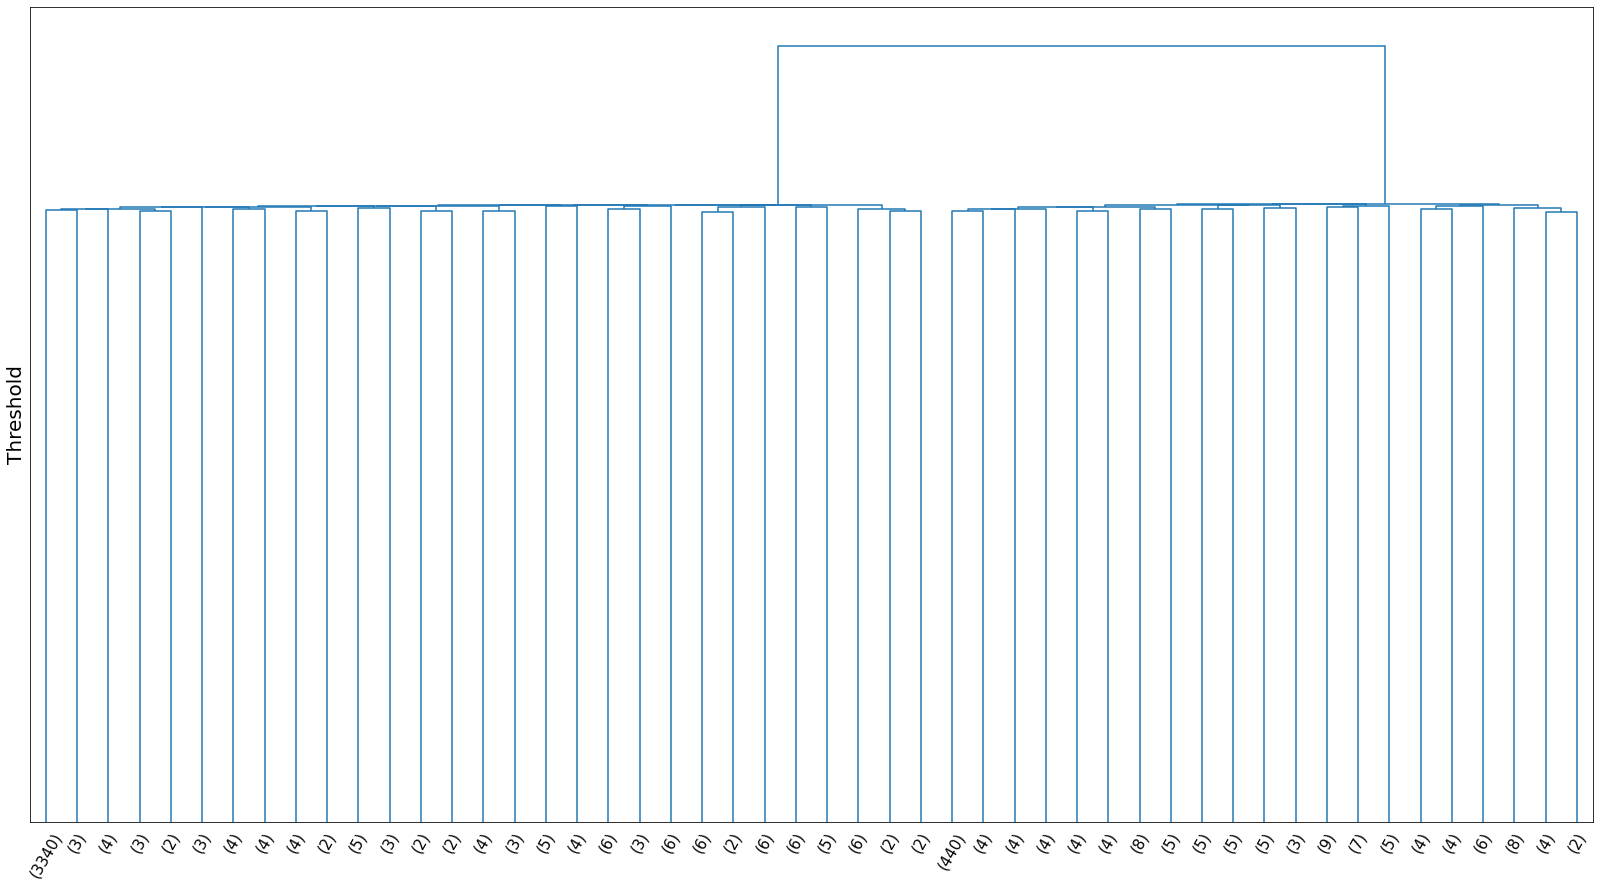

In [5]:
fig, axs = plt.subplots(figsize=(28,15))
R = hy.dendrogram(Z, p=50, truncate_mode='lastp', get_leaves=True, count_sort='descending', ax=axs)
axs.set_yticks([])
axs.set_ylabel('Threshold', fontsize=20)
axs.tick_params(axis='x', labelsize=15, labelrotation = 60)
plt.show()

In [10]:
clust_ix_raw = hy.fcluster(Z,t=.6,criterion='distance')
d = Counter(clust_ix_raw)
pop_clusts = [k[0] for k in sorted(d.items(), key=lambda x: x[1], reverse=True)]
clust_dict = dict(zip(pop_clusts,range(1,len(d)+1)))
clust_ix = np.array([clust_dict[k] for k in clust_ix_raw])

OS_metadata['clust_ix'] = clust_ix
OS_metadata.to_csv('ftir_metadata_clusters_raw.csv', index=False)
#OS_metadata[['spectrum_identity','sample_name','clust_ix']]

In [11]:
cl_means = []
cl_stds = []

for ix in range(1,550):
    cl_array = np.empty((0,len(der_spectra['wavenos'])))
    for k in OS_metadata[OS_metadata['clust_ix']==ix]['sample_name']:
        cl_array = np.vstack([cl_array,np.array(der_spectra[str(k)])])
    cl_array = np.apply_along_axis(integ,1,cl_array)
    cl_means.append(cl_array.mean(axis=0))
    cl_stds.append(cl_array.std(axis=0))

#cl_array = np.empty((0,len(der_spectra['wavenos'])))
#for k in OS_metadata[OS_metadata['clust_ix']==4]['sample_name']:
#    cl_array = np.vstack([cl_array,np.array(der_spectra[k])])
#cl_means.append(integ(cl_array.mean(axis=0)))
#cl_stds.append(integ(cl_array.std(axis=0)))
#plt.plot(der_spectra['wavenos'],cl_means[0])

In [12]:
cl_array = np.empty((0,len(der_spectra['wavenos'])))
for k in OS_metadata[OS_metadata['clust_ix']==4]['sample_name']:
    cl_array = np.vstack([cl_array,np.array(der_spectra[str(k)])])

cl_array = np.apply_along_axis(integ,1,cl_array)

cl_mean1 = cl_array.mean(axis=0)
cl_std1 = cl_array.std(axis=0)
#len(der_spectra['wavenos'])

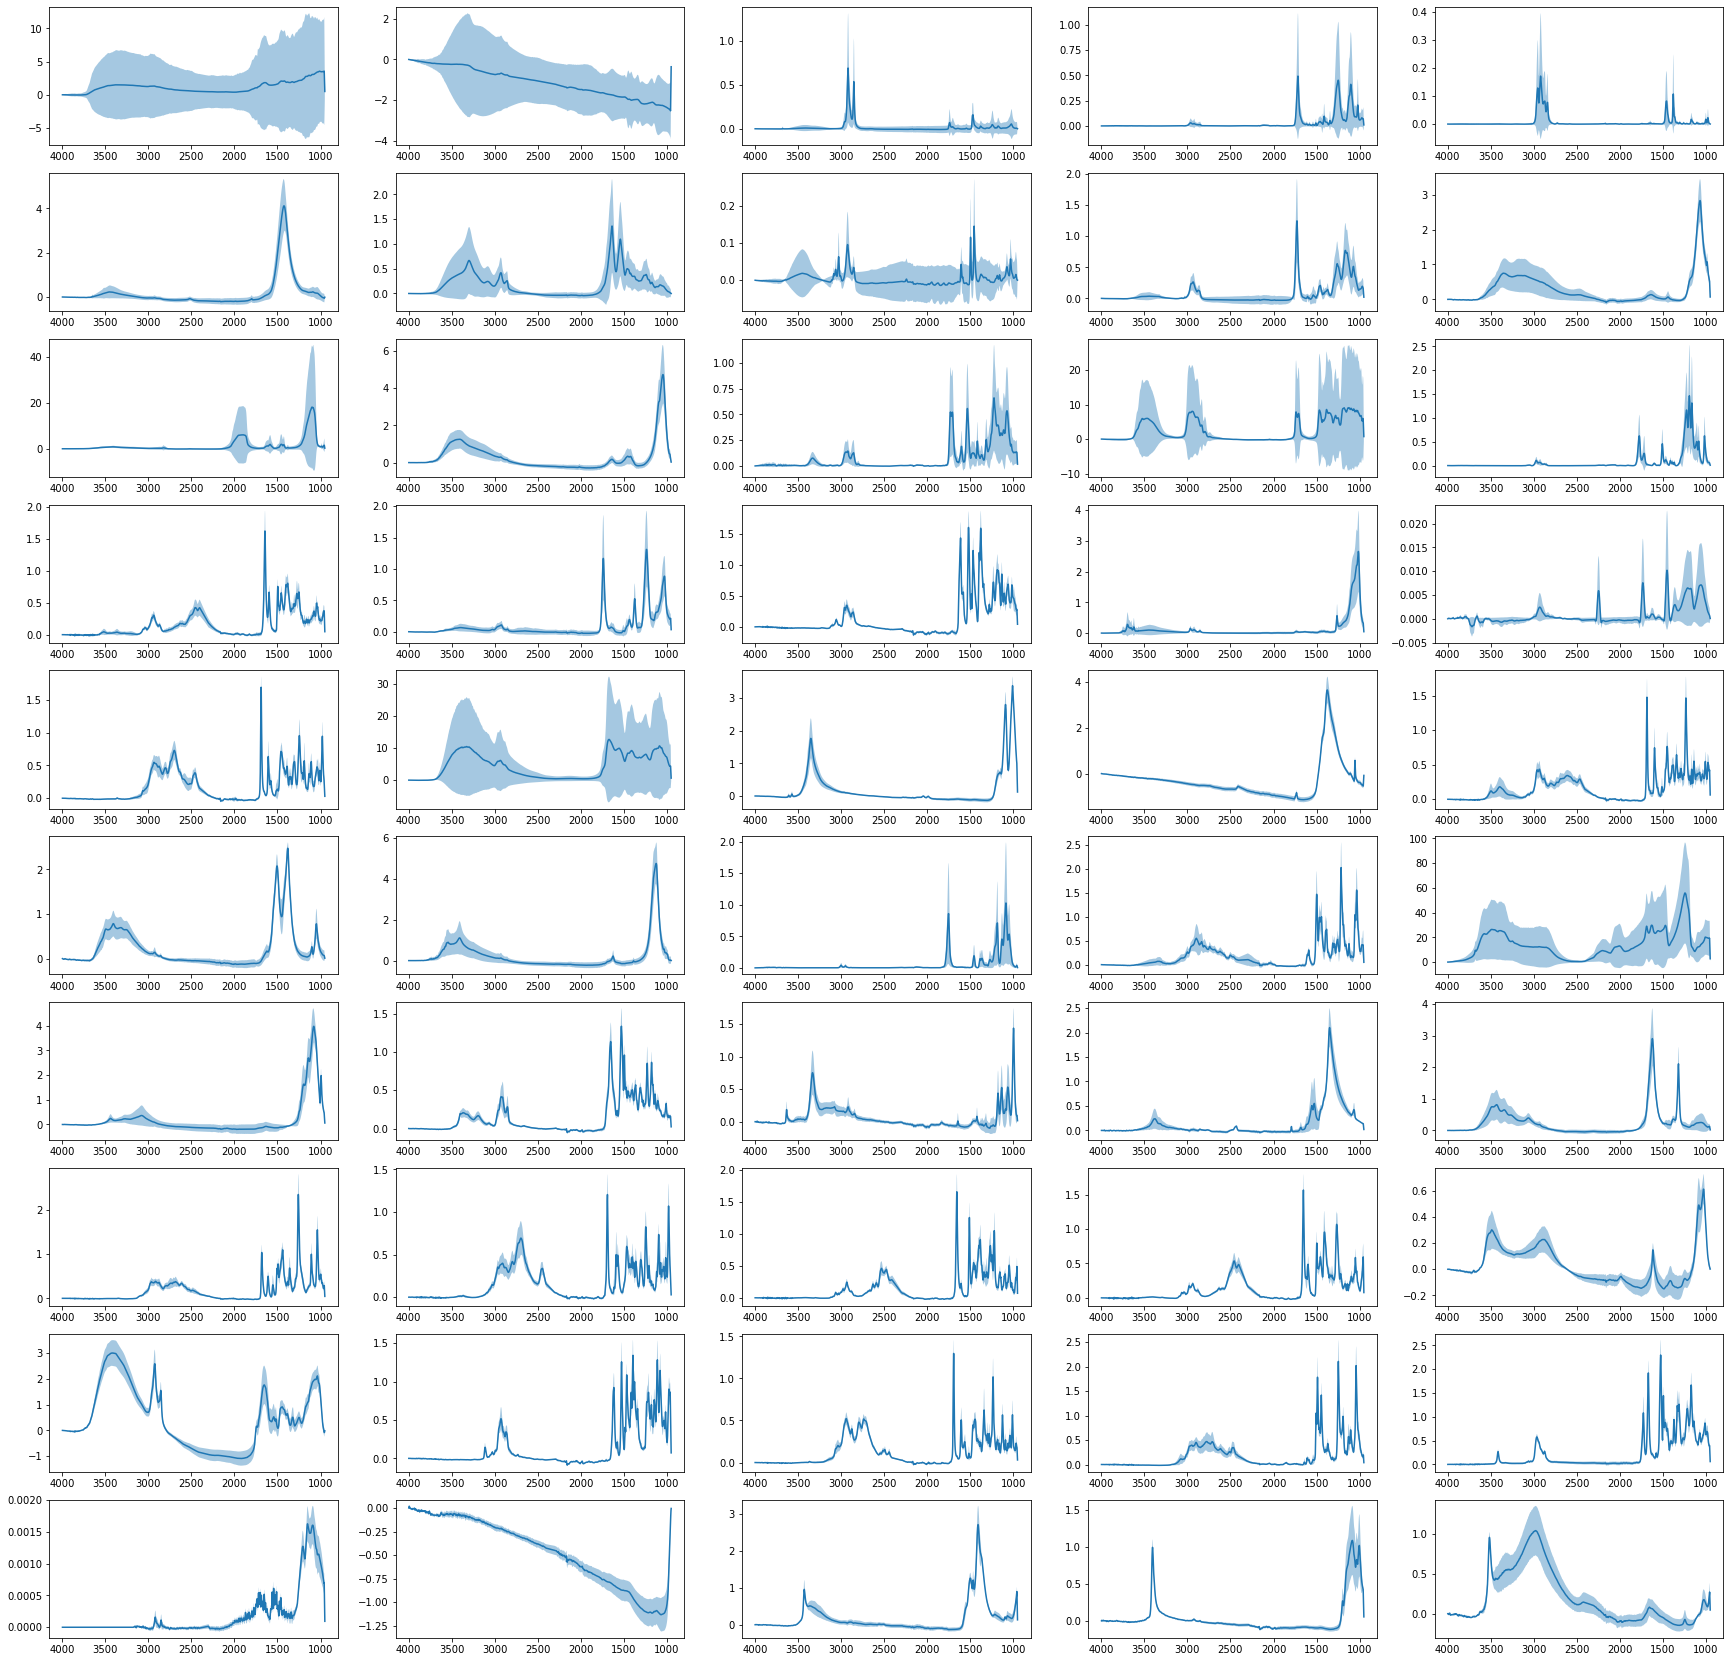

In [13]:
#cl_simplified = pd.read_csv('cluster_keys_simplified.csv')
#simp_key = dict(zip(cl_simplified['index'],cl_simplified['simplified_names']))
fig, axs = plt.subplots(10,5,figsize=(30,30))

for ix in range(10):
    for ix2 in range(5):
        s_ix = ix*5+ix2
        axs[ix,ix2].plot(der_spectra['wavenos'], (cl_means[s_ix]))
        axs[ix,ix2].fill_between(der_spectra['wavenos'], (np.array(cl_means[s_ix])-.5*np.array(cl_stds[s_ix])),
            (np.array(cl_means[s_ix]) + .5*np.array(cl_stds[s_ix])), alpha = .4)
        #ft_sp, ft_nm, ft_id = lib_p.library_fit_1(deriv(cl_means[s_ix],smoothing_window),der_spectra['wavenos'],s_ix)[1:4]
        #integ_bf_spec = integ(ft_sp['spectrum'])
        #nmz_bf = np.max(integ_bf_spec) - np.min(integ_bf_spec)
        #axs[ix,ix2].plot(ft_sp['wavenumbers'], integ_bf_spec/nmz_bf, label = lib_p.catID(ft_id))
        #axs[ix,ix2].text(2700,1.7,'Cluster '+str(s_ix+1)+'\n'+str(s_ix+1), fontsize=12)
        axs[ix,ix2].invert_xaxis()

#plt.savefig('ftir_clusters_raw.png',bbox_inches='tight')


In [14]:
len(clust_ix_raw)
#print(d)
#len(set(clust_ix_raw))
#print(clust_dict)
OS_metadata[OS_metadata['clust_ix']==33]

,sample_name,SpectrumIdentity,SpectrumID,Organization,SpectrumType,Polymer.Category,LibraryType,OWNER,OtherInformation,JCAMP-DX,...,LaserLightUsed,TotalAcquisitionTime_s,DataProcessingProcedure,LevelofConfidenceinIdentification,timestamp,smoother,baseline,DENSITY,spectral_quality,clust_ix
900,c2d629e3c56f3e66073a4149fed78153,Mottramite,Infrared/Processed/Mottramite__R050521-1__Infr...,RRUFF,FTIR,NaN,Minerals,RRUFF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,33
1270,57e448259c6638f686297a42207b8352,Zunyite,Infrared/Processed/Zunyite__R050263-1__Infrare...,RRUFF,FTIR,NaN,Minerals,RRUFF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,33
1271,6ecb8de37f2c92ba63d4f5b22888b8f1,Zunyite,Infrared/Processed/Zunyite__R050553-1__Infrare...,RRUFF,FTIR,NaN,Minerals,RRUFF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,33
1273,d0d9963ba30bf0cc99a0d6b7ae0306be,1 2 polybutadiene,1Primpke,Primpke et al. 2018,FTIR,Other - rubber,"Polymer, Minerals, Organic Materials",NaN,https://doi.org/10.1007/s00216-018-1156-x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,33
2610,a23bbe5444ec63ae3ae9a42c617dddac,Mottramite__R050521-1__Infrared__Infrared_Data...,Mottramite__R050521-1__Infrared__Infrared_Data...,RRUFF,FTIR,NaN,Minerals,unknown,Collection of 882 FTIR absorbance spectra of m...,5.01 $$ datafile exported by Spectragryph v.1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,33
2979,ee901ce4441517f2b6ddf991be38d55b,Zunyite__R050263-1__Infrared__Infrared_Data_Pr...,Zunyite__R050263-1__Infrared__Infrared_Data_Pr...,RRUFF,FTIR,NaN,Minerals,unknown,Collection of 882 FTIR absorbance spectra of m...,5.01 $$ datafile exported by Spectragryph v.1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,33
2980,7634d18b7428a0a50d84297684077fc9,Zunyite__R050553-1__Infrared__Infrared_Data_Pr...,Zunyite__R050553-1__Infrared__Infrared_Data_Pr...,RRUFF,FTIR,NaN,Minerals,unknown,Collection of 882 FTIR absorbance spectra of m...,5.01 $$ datafile exported by Spectragryph v.1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,33
3460,ee1400f0cd422498d004bd5985ac3e00,D-Arabinose (Lot #01902CI),D-Arabinose (Lot #01902CI),SWGDRUG,FTIR,NaN,Drugs,unknown,Collection of 624 FTIR-ATR absorbance spectra ...,5.01 $$ datafile exported by Spectragryph v.1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,33


In [15]:
sorted(d.items(), key=lambda x: x[1], reverse=True)

[(281, 1220),
 (717, 381),
 (194, 278),
 (299, 192),
 (192, 106),
 (566, 104),
 (521, 83),
 (348, 58),
 (230, 45),
 (265, 37),
 (401, 34),
 (264, 30),
 (297, 26),
 (223, 19),
 (507, 18),
 (336, 18),
 (237, 15),
 (429, 15),
 (294, 14),
 (236, 14),
 (133, 14),
 (276, 12),
 (293, 12),
 (714, 12),
 (123, 12),
 (562, 11),
 (399, 11),
 (390, 11),
 (493, 11),
 (275, 9),
 (157, 9),
 (540, 9),
 (159, 8),
 (143, 8),
 (527, 8),
 (449, 8),
 (134, 8),
 (362, 8),
 (337, 8),
 (263, 7),
 (193, 7),
 (426, 7),
 (132, 7),
 (462, 7),
 (536, 7),
 (279, 6),
 (712, 6),
 (284, 6),
 (278, 6),
 (273, 6),
 (224, 6),
 (724, 6),
 (446, 6),
 (494, 6),
 (174, 5),
 (325, 5),
 (560, 5),
 (146, 5),
 (154, 5),
 (319, 5),
 (415, 5),
 (185, 5),
 (94, 5),
 (213, 5),
 (67, 4),
 (287, 4),
 (565, 4),
 (688, 4),
 (718, 4),
 (725, 4),
 (199, 4),
 (65, 4),
 (563, 4),
 (262, 4),
 (518, 4),
 (406, 4),
 (226, 4),
 (497, 4),
 (422, 4),
 (524, 4),
 (374, 4),
 (75, 4),
 (158, 4),
 (286, 3),
 (225, 3),
 (195, 3),
 (308, 3),
 (311, 3),


In [16]:
print(np.count_nonzero(X))
;;print(np.shape(X)[0]*np.shape(X)[1])

11253467
12160350


TypeError: 'NoneType' object is not callable

(-1e-20, 1e-20)

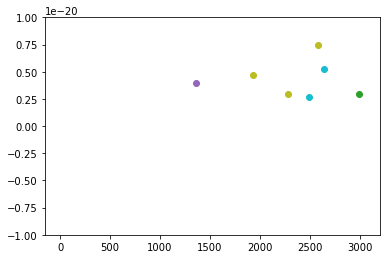

In [ ]:
plt.plot(np.transpose(Xp),'o')
plt.ylim([-10**-20,10**-20])

In [ ]:
OS_library = OS_library.sort_values(by=['sample_name','wavenumber'])


In [ ]:
OS_library[OS_library['sample_name']=='43d59f296a3208e872a5b05cfbe63c39']

,wavenumber,intensity,sample_name
121,900.6088,-4.575128,43d59f296a3208e872a5b05cfbe63c39
122,902.5373,-4.575126,43d59f296a3208e872a5b05cfbe63c39
123,904.4658,-4.575124,43d59f296a3208e872a5b05cfbe63c39
124,906.3943,-4.575120,43d59f296a3208e872a5b05cfbe63c39
125,908.3228,-4.575119,43d59f296a3208e872a5b05cfbe63c39
...,...,...,...
1295,3164.6660,-4.575161,43d59f296a3208e872a5b05cfbe63c39
1296,3166.5940,-4.575161,43d59f296a3208e872a5b05cfbe63c39
1297,3168.5230,-4.575161,43d59f296a3208e872a5b05cfbe63c39
1298,3170.4510,-4.575160,43d59f296a3208e872a5b05cfbe63c39


In [ ]:
OS_metadata

,sample_name,SpectrumIdentity,SpectrumID,Organization,SpectrumType,Polymer.Category,LibraryType,OWNER,OtherInformation,JCAMP-DX,...,LaserLightUsed,TotalAcquisitionTime_s,DataProcessingProcedure,LevelofConfidenceinIdentification,timestamp,smoother,baseline,DENSITY,spectral_quality,clust_ix
0,43d59f296a3208e872a5b05cfbe63c39,HDPE,HDPESample 1Beauty C,Chabuka et al. 2020,FTIR,polyolefins,Polymers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,3
1,365a8bc503d4f77b307b6dcad63463f3,HDPE,HDPESample 2Beauty C,Chabuka et al. 2020,FTIR,polyolefins,Polymers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,3
2,566b2a79d20b5218b804bb9b308ba3db,HDPE,HDPESample 3Beauty C,Chabuka et al. 2020,FTIR,polyolefins,Polymers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,3
3,0f74ffeb75118bd6f2195a789e73acb1,HDPE,HDPESample 4Beauty C,Chabuka et al. 2020,FTIR,polyolefins,Polymers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,3
4,6112ecd7efd9f0b916b1be5a4506efe3,HDPE,HDPESample 5Beauty C,Chabuka et al. 2020,FTIR,polyolefins,Polymers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982,b367d1fa98359d89e08924bd7faa1647,R 4. Black Bridgestone Tire Fragment,R 4. Black Bridgestone Tire Fragment,"FLOPP, De Frond et al. 2021",FTIR,NaN,Polymers,Nicolet,https://doi.org/10.1021/acs.analchem.1c02549,5.01 $$ Nicolet v. 970,...,NaN,11.18 sec,NaN,NaN,NaN,NaN,NaN,NaN,2.4,1
3983,aeb35b60435bc165428ffdc63c730b79,R 5. Black Michelin Tire Fragment,R 5. Black Michelin Tire Fragment,"FLOPP, De Frond et al. 2021",FTIR,NaN,Polymers,Nicolet,https://doi.org/10.1021/acs.analchem.1c02549,5.01 $$ Nicolet v. 970,...,NaN,11.18 sec,NaN,NaN,NaN,NaN,NaN,NaN,2.4,1
3984,57f48df7ee3098da99af60ba1b506516,R 6. Black Bike Tire Fragment,R 6. Black Bike Tire Fragment,"FLOPP, De Frond et al. 2021",FTIR,NaN,Polymers,Nicolet,https://doi.org/10.1021/acs.analchem.1c02549,5.01 $$ Nicolet v. 970,...,NaN,11.18 sec,NaN,NaN,NaN,NaN,NaN,NaN,1.9,1
3985,429b39e439fcf8f639883323d0b6ab35,R 8. White Bike Tire Fragment,R 8. White Bike Tire Fragment,"FLOPP, De Frond et al. 2021",FTIR,NaN,Polymers,Nicolet,https://doi.org/10.1021/acs.analchem.1c02549,5.01 $$ Nicolet v. 970,...,NaN,11.18 sec,NaN,NaN,NaN,NaN,NaN,NaN,1.8,1
